Бежим по входному изображению сверткой 5x5 с шагом 5. Классифицируем каждый кусочек как сторону доски кроссэнтропией.

In [1]:
cd ..

/home/bfilippov/whiteboard


In [28]:
import os
import keras
import pandas as pd
import ast
import threading

import cv2
import tensorflow as tf
import numpy as np
from keras.layers import Input
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Conv2D, MaxPooling2D,
    BatchNormalization, Dropout, UpSampling2D
)
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import LeakyReLU
from models.model_zoo import residual_block
from models.image_generator import whiteboard_images


def cv_feature_maps(image):
    # special mask used to ignore image-augmentation artifacts
    alpha = image[:, :, 3].copy()

    gray = (cv2.cvtColor(image[:, :, :3].astype(np.float32),
            cv2.COLOR_RGB2GRAY) * 255).astype(np.uint8)
    edges = cv2.Canny(gray, 100, 250)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 25, minLineLength=50,
                            maxLineGap=50)

    corners = cv2.cornerHarris(edges,2,3,0.01)

    hough = np.zeros(gray.shape, np.float)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(hough, (x1, y1), (x2, y2), 1, 2)

    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)

    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    features = [gray, edges, corners, hough, sobel, binary, alpha]

    def norm(img):
        return cv2.normalize(img, img, 0, 1, norm_type=cv2.NORM_MINMAX,
                             dtype=cv2.CV_32F)
    feature_maps = [norm(img) for img in features]
    return np.stack(feature_maps, axis=2)


os.chdir('/home/bfilippov/whiteboard')

train = pd.read_csv('source/train.csv')
test = pd.read_csv('source/test.csv')
train['labels'] = train['labels'].map(ast.literal_eval)
test['labels'] = test['labels'].map(ast.literal_eval)

valid = train.sample(frac=0.2, random_state=1313)
train = train.drop(valid.index)

smooth = 1e-12

def jaccard_coef(y_true, y_pred):
    """Compute jaccard coefficient."""
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    """Compute jaccard coefficient over pixels."""
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def jaccard_loss(y_true, y_pred):
    """Loss on jaccard coefficient."""
    return 1 - jaccard_coef(y_true, y_pred)


config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
sess = tf.Session(config=config)
K.set_session(sess)


def scale(N, i, scaler=2):
    """N * (i ** scaler)."""
    return int(N * (scaler**i))


def down_res(name, in_layer, dropout_pb, nb_filters, patch_size):
    """
    Submerge U-net. Increases feature map size and decreases image size.

    Feed it to residual block.
    """
    downsampled = downsample(in_layer, 'pool_' + name)
    normalized = BatchNormalization(name='pool_norm_' + name)(downsampled)
    dropped = Dropout(dropout_pb)(normalized)
    deepened = Conv2D(nb_filters, (patch_size, patch_size),
                      name='deep_' + name,
                      padding='same',
                      strides=(1, 1),
                      activation=LeakyReLU())(dropped)
    return residual_block(name, deepened, dropout_pb, nb_filters, patch_size)


def up_res(name, in_layer, par_layer, dropout_pb, nb_filters, patch_size):
    """
    Uplift U-net. Decreases feature map size, increases image size.

    Concat with previous layer. Feed it to residual block.
    """
    normalized = BatchNormalization(name='up_norm_' + name)(in_layer)
    dropped = Dropout(dropout_pb)(normalized)
    shallowed = Conv2D(nb_filters, (patch_size, patch_size),
                       name='shallow_' + name,
                       padding='same',
                       strides=(1, 1),
                       activation=LeakyReLU())(dropped)
    renormalized = BatchNormalization(name='shallow_norm_' + name)(shallowed)
    redropped = Dropout(dropout_pb)(renormalized)
    upsampled = upsample(redropped, par_layer, name)
    return residual_block(name, upsampled, dropout_pb, 2 * nb_filters,
                          patch_size)


def downsample(in_layer, layer_name):
    """Decrease image size."""
    return MaxPooling2D(pool_size=(2, 2), name=layer_name)(in_layer)


def upsample(in_layer, par_layer, layer_name):
    """Increase image size and concat with other layer."""
    upsample_name = 'up_' + layer_name
    merge_name = 'concat_' + layer_name
    return concatenate([UpSampling2D(size=(2, 2), name=upsample_name)(in_layer),
                        par_layer], axis=3, name=merge_name)


model_weights = ('/home/bfilippov/whiteboard/models/weights/'
                 'big_unet_resnet_detector_jaccard_v2.hf5')
nb_cv_features = 7
input_height = 160
input_width = 160
nb_filters = 16
patch_size = 3
dropout_pb = 0.5

img_size = (input_height, input_width)
img_dir = '/ssd/whiteboard/source'
batch_size = 62
epoch_size = 1024


input_layer = Input(shape=(None, None, nb_cv_features),
                    name='input_layer')

downsampled = downsample(input_layer, 'pool_I')
normalized = BatchNormalization(name='pool_norm_I')(downsampled)
dropped = Dropout(dropout_pb)(normalized)
deepened = Conv2D(nb_filters, (patch_size, patch_size), name='deep_I',
                         padding='same',
                         strides=(1, 1),
                         activation=LeakyReLU())(dropped)

conv1 = residual_block('I', deepened, dropout_pb, nb_filters, patch_size)


conv2 = down_res('II', conv1, dropout_pb, scale(nb_filters, 1), patch_size)

conv3 = down_res('III', conv2, dropout_pb, scale(nb_filters, 2), patch_size)

conv4 = down_res('IV', conv3, dropout_pb, scale(nb_filters, 3), patch_size)

conv5 = down_res('V', conv4, dropout_pb, scale(nb_filters, 4), patch_size)

conv6 = up_res('VI', conv5, conv4, dropout_pb, scale(nb_filters, 3),
               patch_size)

conv7 = up_res('VII', conv6, conv3, dropout_pb, scale(nb_filters, 2),
               patch_size)

conv8 = up_res('VIII', conv7, conv2, dropout_pb, scale(nb_filters, 1),
               patch_size)

conv9 = up_res('IX', conv8, conv1, dropout_pb, nb_filters, patch_size)

final_upsampling = UpSampling2D(size=(2, 2), name='up_X')(conv9)

final_batch_norm = BatchNormalization(name='norm_X')(final_upsampling)
final_dropout = Dropout(dropout_pb)(final_batch_norm)

# compute probability of corner for
# each patch using aggregated feature maps.
output_layer = Conv2D(1, (patch_size, patch_size), padding='same',
                      strides=(1, 1),
                      activation='sigmoid',
                      name='sigmoid_conv')(final_dropout)

model = Model(inputs=input_layer, outputs=output_layer)

if os.path.exists(model_weights):
    model.load_weights(model_weights, by_name=True)

training_log_path = 'training.log'
initial_epoch = 0
initial_learning_rate = 0.001
if os.path.exists(training_log_path):
    try:
        training_log = pd.read_csv(training_log_path)
        if training_log.shape[0] > 0:
            initial_epoch = training_log.iloc[-1]['epoch'] + 1
            initial_learning_rate = training_log.iloc[-1]['lr']
    except pd.io.common.EmptyDataError:
        pass


optimizer = keras.optimizers.Adam(lr=initial_learning_rate)
model.compile(optimizer=optimizer, loss=jaccard_loss,
              metrics=[jaccard_coef, jaccard_coef_int])

class locked:
    def __init__(self, it):
        self.lock = threading.Lock()
        self.it = it

    def __next__(self):
        with self.lock:
            batch_x, batch_y = next(self.it)
            patch_x = np.zeros(batch_x.shape[:-1] + (nb_cv_features,))
            for i in range(batch_x.shape[0]):
                patch_x[i] = cv_feature_maps(batch_x[i])
            print("X:", patch_x.shape, "y:", batch_y.shape)
            return patch_x, batch_y
        
train_imgs = locked(whiteboard_images(train, img_dir, img_size,
                                     batch_size=batch_size))
valid_imgs = locked(whiteboard_images(valid, img_dir, img_size,
                                     batch_size=batch_size, seed=1313))
test_imgs = locked(whiteboard_images(test, img_dir, img_size,
                                    batch_size=batch_size))

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import patches

img_ix = 3

height_patches = input_height / 1
width_patches = input_width / 1
height_len = input_height / height_patches
width_len = input_width / width_patches

def draw_rect(x, y, p, color):
    return patches.Rectangle(
        (y * height_len, x * width_len),
        height_len,
        width_len,
        alpha=p,
        color = color
    )

def draw_rects(plt, matrix, color):
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.add_patch(draw_rect(i, j, matrix[i, j], color))

        

def draw_example(imgs, include_alpha=True, img_ix=3):
    test_batch_x, test_batch_y = next(imgs)
    
    if not include_alpha:
        test_batch_x = test_batch_x.copy()
        for i in range(batch_size):
            test_batch_x[i, :, :, 4] = np.ones(test_batch_x.shape[1:3])
    
    plt.subplot(141)
    print(test_batch_x.shape, test_batch_y.shape)
    plt.imshow(test_batch_x[img_ix][:, :, 0], cmap='gray')
    plt.imshow(test_batch_y[img_ix, :, :, 0], cmap='jet', alpha=0.5) 
    #draw_rects(plt.gca(), , 'blue')

    prediction_y = model.predict_on_batch(test_batch_x)

    plt.subplot(142)
    print(prediction_y.shape)
    plt.imshow(test_batch_x[img_ix][:, :, 0], cmap='gray')
    plt.imshow(prediction_y[img_ix, :, :, 0], cmap='jet', alpha=0.5) 
    #draw_rects(plt.gca(), prediction_y[img_ix] 
               #/ prediction_y[img_ix].max()
    #           , 'red')


    plt.subplot(143)
    plt.imshow(test_batch_x[img_ix, :, :, 4], cmap='gray')
    #plt.plot(test_batch_y[img_ix][6:10], test_batch_y[img_ix][2:6], '+')
    #plt.plot(predictions[img_ix][2:6], predictions[img_ix][6:10], 'o')

    plt.subplot(144)
    plt.imshow(cv2.dilate(prediction_y[img_ix], None), cmap='gray')
    print(prediction_y.shape)

/home/bfilippov/whiteboard/models/image_generator.py:136: RuntimeWarning: invalid value encountered in true_divide
  t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
/home/bfilippov/whiteboard/models/image_generator.py:137: RuntimeWarning: invalid value encountered in less
  t[t < a] = a
/home/bfilippov/whiteboard/models/image_generator.py:138: RuntimeWarning: invalid value encountered in greater
  t[t > b] = b


X: (62, 160, 160, 7) y: (62, 160, 160, 1)
(62, 160, 160, 7) (62, 160, 160, 1)
(62, 160, 160, 1)
(62, 160, 160, 1)


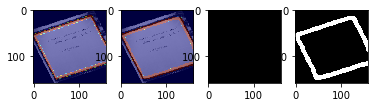

In [30]:
draw_example(valid_imgs, include_alpha=False)

X: (62, 160, 160, 7) y: (62, 160, 160, 1)
(62, 160, 160, 7) (62, 160, 160, 1)
(62, 160, 160, 1)
(62, 160, 160, 1)


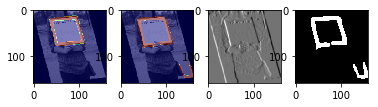

In [31]:
draw_example(test_imgs)

X: (1, 160, 160, 7) y: (1, 160, 160, 1)
(1, 160, 160, 7) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


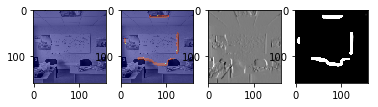

In [33]:
from skimage import img_as_float

import os
img_dir = '/home/bfilippov/our_room/'

def arr(img):
    img = img_as_float(cv2.imread(img))
    img = cv2.resize(img, (160, 160))
    cv2.normalize(img, img, 0, 1, norm_type=cv2.NORM_MINMAX,
              dtype=cv2.CV_32F)
    img = np.dstack([img, np.zeros((160, 160))])
    img = np.array([img])
    
    return img

imgs = [(arr(os.path.join(img_dir, fname)), np.zeros((1, 160,160, 1))) for fname in os.listdir(img_dir)]

draw_example(locked(imgs.__iter__()), img_ix=0)


X: (1, 160, 160, 7) y: (1, 160, 160, 1)
(1, 160, 160, 7) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


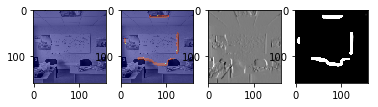

In [35]:
draw_example(locked(imgs[0:].__iter__()), img_ix=0)

X: (1, 160, 160, 7) y: (1, 160, 160, 1)
(1, 160, 160, 7) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


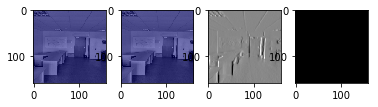

In [36]:
draw_example(locked(imgs[1:].__iter__()), img_ix=0)

X: (1, 160, 160, 7) y: (1, 160, 160, 1)
(1, 160, 160, 7) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


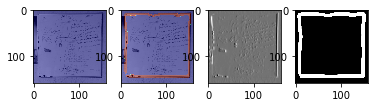

In [37]:
draw_example(locked(imgs[2:].__iter__()), img_ix=0)

X: (1, 160, 160, 7) y: (1, 160, 160, 1)
(1, 160, 160, 7) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


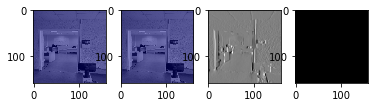

In [39]:
draw_example(locked(imgs[3:].__iter__()), img_ix=0)